In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  
sns.set(style="darkgrid")  

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

In [2]:
#read data
reddit_data_df1 = pd.read_csv("/home/cliftonh/github/UCB_207_sec01_fin_nlp/data/ch_sample_selections_data.csv")
reddit_data_df2 = pd.read_csv("/home/cliftonh/github/UCB_207_sec01_fin_nlp/data/forex_finance_finindependence_forex.csv")
reddit_data_df3 = pd.read_csv("/home/cliftonh/github/UCB_207_sec01_fin_nlp/data/sample_wsb_gme_personalfin_stock.csv")
print(reddit_data_df1.shape)
print(reddit_data_df2.shape)
print(reddit_data_df3.shape)

(15000, 25)
(6104, 25)
(16000, 25)


In [3]:
df_combined = pd.concat([reddit_data_df1, reddit_data_df2], axis=0, ignore_index=True)
df_combined = pd.concat([df_combined, reddit_data_df3], axis=0, ignore_index=True)
print(df_combined.shape)

(37104, 25)


In [4]:
# total_awards_received	num_comments title (positve, negative, neutral), selftext (positve, negative, neutral), created (hour of day)
df_combined['created'] = pd.to_datetime(df_combined['created'])
df_combined['hour_of_day'] = df_combined['created'].dt.hour
columns_to_retain = ['total_awards_received', 'num_comments', 'title', 'selftext', 'hour_of_day', 'score']
df_combined = df_combined[columns_to_retain]

In [5]:
np.random.seed(42)
df_shuffled = df_combined.sample(frac=1).reset_index(drop=True)

# Create the Y dataframe containing the outcome of interest
Y = df_shuffled[['score']]
print('Shape of Y:', Y.shape)

# Create the X dataframe containing the features of interest. 'hour_of_day'
X = df_shuffled[['total_awards_received', 'num_comments', 'title', 'selftext']]
print('Shape of X:', X.shape)

Shape of Y: (37104, 1)
Shape of X: (37104, 4)


In [6]:
# First split: Split into training + validation and test sets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

# Second split: Split the training + validation set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.25, random_state=1234)

In [7]:
from sklearn.preprocessing import StandardScaler
# Columns to standardize
cols_to_standardize_X = ['total_awards_received', 'num_comments']
cols_to_standardize_Y = ['score']

# Initialize the scaler
scaler = StandardScaler()

# Standardize the columns
X_train[cols_to_standardize_X] = scaler.fit_transform(X_train[cols_to_standardize_X])
X_val[cols_to_standardize_X] = scaler.fit_transform(X_val[cols_to_standardize_X])
X_test[cols_to_standardize_X] = scaler.fit_transform(X_test[cols_to_standardize_X])

Y_train[cols_to_standardize_Y] = scaler.fit_transform(Y_train[cols_to_standardize_Y])
Y_val[cols_to_standardize_Y] = scaler.transform(Y_val[cols_to_standardize_Y])
Y_test[cols_to_standardize_Y] = scaler.transform(Y_test[cols_to_standardize_Y])

# Convert specific columns to string
X_train['title'] = X_train['title'].astype(str)
X_train['selftext'] = X_train['selftext'].astype(str)

X_val['title'] = X_val['title'].astype(str)
X_val['selftext'] = X_val['selftext'].astype(str)

X_test['title'] = X_test['title'].astype(str)
X_test['selftext'] = X_test['selftext'].astype(str)

# Display the final DataFrame
print(Y_train)

          score
1460  -0.069678
14301 -0.068942
32674 -0.065263
2330   0.073070
31918 -0.062320
...         ...
7857  -0.067470
1533  -0.061584
31707 -0.068206
13669 -0.066735
15838  0.040694

[22262 rows x 1 columns]


In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\clift\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
def classify_sentiment(text):
    if not text:
        return 'neutral'
    sentiment_scores = sid.polarity_scores(text)
    compound = sentiment_scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [10]:
# Apply the function to classify sentiment
X_train['title'] = X_train['title'].apply(classify_sentiment)
X_train['selftext'] = X_train['selftext'].apply(classify_sentiment)

X_val['title'] = X_val['title'].apply(classify_sentiment)
X_val['selftext'] = X_val['selftext'].apply(classify_sentiment)

X_test['title'] = X_test['title'].apply(classify_sentiment)
X_test['selftext'] = X_test['selftext'].apply(classify_sentiment)

In [11]:
# One-hot encode 'title'
X_train = pd.get_dummies(X_train, columns=['title'])
X_val = pd.get_dummies(X_val, columns=['title'])
X_test = pd.get_dummies(X_test, columns=['title'])
X_train = pd.get_dummies(X_train, columns=['selftext'])
X_val = pd.get_dummies(X_val, columns=['selftext'])
X_test = pd.get_dummies(X_test, columns=['selftext'])

<Axes: >

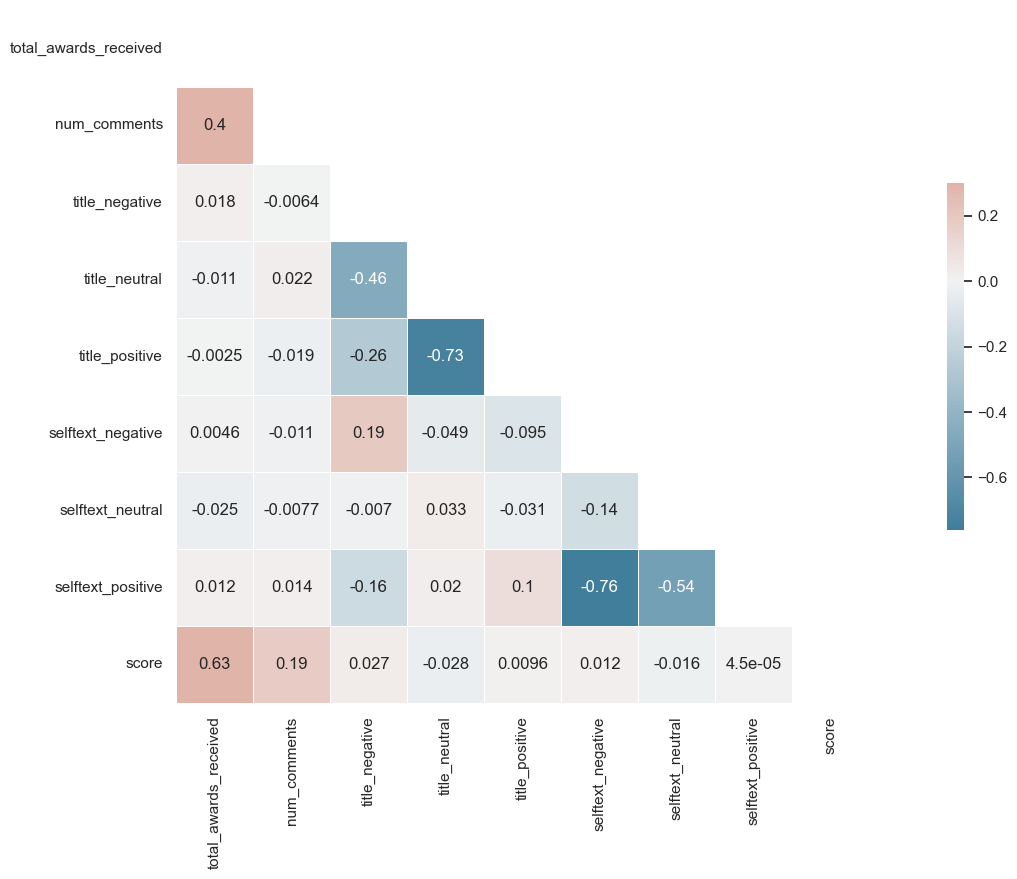

In [12]:
sns.set_theme(style="white")
data_std = pd.concat([X_train, Y_train], axis=1)
# Compute the correlation matrix
corr = data_std.corr()
#print(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
def build_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras."""
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
        units=1,        # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,
        kernel_initializer=tf.ones_initializer,
        bias_initializer=tf.ones_initializer,
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    return model

In [14]:
tf.random.set_seed(0)

# 2. Build and compile model
num_features = X_train.shape[1]
learning_rate = 0.0001
model_tf = build_model(num_features, learning_rate)

# 3. Fit the model
num_epochs = 25
batch_size = 8

history = model_tf.fit(
    X_train, Y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val)
)

# Learned parameters of the model
weights, bias = model_tf.layers[0].get_weights()
print("First 5 learned parameters:", weights[0:5])
print("Learned bias:", bias)

# Loss at the final epoch for training and validation data
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
print("Final training loss:", train_loss)
print("Final validation loss:", val_loss)

# The percentage difference between the losses observed on the training and validation datasets
percentage_difference = ((val_loss - train_loss) / train_loss) * 100
print("Percentage difference between training and validation losses:", percentage_difference)


Epoch 1/25


c:\Users\clift\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 998us/step - loss: 7.7631 - mse: 7.7631 - val_loss: 1.6930 - val_mse: 1.6930
Epoch 2/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 889us/step - loss: 2.4001 - mse: 2.4001 - val_loss: 0.6929 - val_mse: 0.6929
Epoch 3/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 2s 849us/step - loss: 1.8553 - mse: 1.8553 - val_loss: 0.5592 - val_mse: 0.5592
Epoch 4/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 2s 862us/step - loss: 1.7831 - mse: 1.7831 - val_loss: 0.5234 - val_mse: 0.5234
Epoch 5/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step - loss: 1.7505 - mse: 1.7505 - val_loss: 0.5017 - val_mse: 0.5017
Epoch 6/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - loss: 1.7218 - mse: 1.7218 - val_loss: 0.4851 - val_mse: 0.4851
Epoch 7/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 957us/step - loss: 1.6970 - mse: 1.6970 - val_loss: 0.4721 - val_mse: 0.4721
Epoch 8/25
2783/2783 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.6770 - mse: 1.6770 - val_loss: 0.4622 - val_mse: 0.4622
Epoch 9/25
2783/2783 ━━━━━━━━━━━━━━━━

In [15]:
train_loss, train_accuracy = model_tf.evaluate(X_train, Y_train, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(X_val, Y_val, verbose=0)
test_loss, test_accuracy = model_tf.evaluate(X_test, Y_test, verbose=0)

print(f"Accuracy of train: {train_accuracy:.4f}")
print(f"Accuracy of validation: {val_accuracy:.4f}")
print(f"Accuracy of test: {test_accuracy:.4f}")

Accuracy of train: 0.5954
Accuracy of validation: 0.4315
Accuracy of test: 0.4908
